In [168]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import confusion_matrix,plot_confusion_matrix, cohen_kappa_score, accuracy_score, classification_report, fbeta_score, make_scorer
from sklearn.metrics import mean_squared_error, r2_score
import math
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
pd.set_option('display.max_columns', None)
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import LinearSVR
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
import seaborn as sns
from imblearn.under_sampling import TomekLinks
tl = TomekLinks('majority')

C:\Users\Nickolaus Smith\anaconda3\lib\site-packages\imblearn\utils\_validation.py:635: FutureWarning: Pass sampling_strategy=majority as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.9 "


In [244]:
def run_model(model,X,Y,scaled):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
    if scaled=="yes":
        scaler_x = StandardScaler().fit(X_train)
        X_train_scaled = pd.DataFrame(scaler_x.transform(X_train),columns=X.columns)
        X_test_scaled = pd.DataFrame(scaler_x.transform(X_test),columns=X.columns)
    elif scaled=="no":
        X_train_scaled=X_train
        X_test_scaled=X_test
    pm = model
    regression = pm.fit(X_train_scaled, y_train['Score'])
    predictions = regression.predict(X_test_scaled)
    predictions_df = pd.DataFrame(predictions,columns=["pred_scores"])
    mse = mean_squared_error(y_test['Score'], predictions)
    print("The MSE value is: ",round(mse,4))
    
    rmse = math.sqrt(mse)
    print("The RMSE value is: ",round(rmse,4))
    
    r2 = r2_score(y_test['Score'], predictions)
    print("The R2 value is: ",round(r2,4))
    
    N = len(X_test_scaled)
    p = X_test_scaled.shape[1]
    adj_r2 = 1-((1-r2)*(N-1)/(N-p-1))
    print("The R_adj^{2} value  is: ",round(adj_r2,4))

    regression2 = pm.fit(X_train_scaled, y_train['Opponent Score'])
    predictions2 = regression2.predict(X_test_scaled)
    predictions_df2 = pd.DataFrame(predictions2,columns=["Opp_pred_scores"])
    
    
    mse = mean_squared_error(y_test['Opponent Score'], predictions2)
    print("The MSE value is: ",round(mse,4))
    
    rmse = math.sqrt(mse)
    print("The RMSE value is: ",round(rmse,4))
    
    r2 = r2_score(y_test['Opponent Score'], predictions2)
    print("The R2 value is: ",round(r2,4))
    
    N = len(X_test_scaled)
    p = X_test_scaled.shape[1]
    adj_r2 = 1-((1-r2)*(N-1)/(N-p-1))
    print("The R_adj^{2} value  is: ",round(adj_r2,4))
    
    final=pd.concat([X_test, y_test],axis=1)
    final['predictions']=predictions
    final['opp predictions']=predictions2
    
    finalscore=list(final['Score'])
    finalline=list(final['Line Open'])
    finalopp=list(final['Opponent Score'])
    finalcover=[]
    for i in range(len(finalscore)):
        if finalscore[i]+finalline[i]>finalopp[i]:
            finalcover.append('Yes')
        else:
            finalcover.append('No')
    final['Cover?']=finalcover
    
    predfinalscore=list(final['predictions'])
    predfinalline=list(final['Line Open'])
    predfinalopp=list(final['opp predictions'])
    predfinalcover=[]
    for i in range(len(predfinalscore)):
        if (predfinalscore[i])+predfinalline[i]>(predfinalopp[i]):
            predfinalcover.append('Yes')
        else:
            predfinalcover.append('No')
    final['Pred_Cover?']=predfinalcover   
    safebet=[]
    for i in range(len(finalscore)):
        if (predfinalscore[i]+predfinalline[i])>(predfinalopp[i]+5):
            safebet.append('Yes')
        elif (predfinalscore[i]+(predfinalline[i]+3.5))<predfinalopp[i]:   
            safebet.append('Yes')
        else:
            safebet.append('No')
    final['safebet?']=safebet

    final['Pred_Cover?']=predfinalcover  
    final['Cover?']=finalcover
    
    safepredfinalscore=list(final['predictions'][final['safebet?'] == 'Yes'])
    safepredfinalline=list(final['Line Open'][final['safebet?'] == 'Yes'])
    safepredfinalopp=list(final['opp predictions'][final['safebet?'] == 'Yes'])
    safepredfinalcover=[]

      
    for i in range(len(safepredfinalscore)):
        if (safepredfinalscore[i])+safepredfinalline[i]>(safepredfinalopp[i]):
            safepredfinalcover.append('Yes')
        else:
            safepredfinalcover.append('No')
    
    
    print("Model Results")
    print("The accuracy of the model on test set is: %4.2f " % accuracy_score(final['Cover?'], predfinalcover))
    print("The Kappa of your model is: %4.2f" % (cohen_kappa_score(final['Cover?'], predfinalcover)))
    print(cohen_kappa_score)
    print("------ Classification_Report------ ")
    print(classification_report(final['Cover?'], predfinalcover))
    print(" =================================================================== ")
    return final,X_train_scaled,y_train

In [265]:
data=pd.read_csv(r"C:\Users\Nickolaus Smith\Desktop\Final Project\lines4.csv")

In [267]:
data = data[data.Home != 'N']

In [6]:
def clean_features(data):
    
    data=data.drop(columns=['Ties', 'Opponent Ties','Home','test'])
    data=data.dropna()
    data.columns=['Date', 'Team', 'Opponent', 'Score', 'Opponent Score',
       'Playoff Game?', 'Odds Open', 'Line Open', 'Win %', 'Total DVOA',
       'Offense DVOA', 'Defense DVOA', 'Special Teams DVOA', 'PassOffense',
       'RushOffense', 'PassDefense', 'RushDefense', 'Opponent Win %',
       'Opponent Total DVOA', 'Opponent Offense DVOA', 'Opponent Defense DVOA',
       'Opponent Special Teams DVOA', 'Opponent PassOffense',
       'Opponent RushOffense', 'Opponent PassDefense',
       'Opponent RushDefense', 'Wins', 'Losses', 'Opponent Wins',
       'Opponent Losses', 'Cover?']
    return data

In [7]:
data

,Date,Team,Opponent,Score,Opponent Score,Home,Playoff Game?,Odds Open,Line Open,Win %,Total DVOA,Offense DVOA,Defense DVOA,Special Teams DVOA,PassOffense,RushOffense,PassDefense,RushDefense,Opponent Win %,Opponent Total DVOA,Opponent Offense DVOA,Opponent Defense DVOA,Opponent Special Teams DVOA,Opponent PassOffense,Opponent RushOffense,test,Opponent PassDefense,Opponent RushDefense,Wins,Losses,Ties,Opponent Wins,Opponent Losses,Opponent Ties,Cover?
0,2020 playoffs,TB,KC,31,9,Y,Y,2.55,3.5,0.6875,0.316,0.198,-0.146,-0.029,0.371,-0.020,-0.054,-0.314,0.875,0.195,0.239,0.049,0.005,0.490,-0.056,6.7,0.067,0.026,11.0,5.0,NaN,14.0,2.0,NaN,Yes
1,2020 playoffs,KC,BUF,38,24,Y,Y,1.66,-2.5,0.875,0.195,0.239,0.049,0.005,0.490,-0.056,0.067,0.026,0.8125,0.238,0.156,-0.023,0.059,0.433,-0.150,2.2,0.022,-0.082,14.0,2.0,NaN,13.0,3.0,NaN,Yes
2,2020 playoffs,GB,TB,26,31,Y,Y,1.50,-4.0,0.8125,0.259,0.291,0.005,-0.027,0.520,0.030,0.051,-0.057,0.6875,0.316,0.198,-0.146,-0.029,0.371,-0.020,-5.4,-0.054,-0.314,13.0,3.0,NaN,11.0,5.0,NaN,No
3,2020 playoffs,NO,TB,20,30,Y,Y,1.52,-3.5,0.75,0.333,0.107,-0.190,0.036,0.166,0.095,-0.147,-0.256,0.6875,0.316,0.198,-0.146,-0.029,0.371,-0.020,-5.4,-0.054,-0.314,12.0,4.0,NaN,11.0,5.0,NaN,No
4,2020 playoffs,KC,CLE,22,17,Y,Y,1.20,-10.0,0.875,0.195,0.239,0.049,0.005,0.490,-0.056,0.067,0.026,0.6875,-0.056,0.054,0.074,-0.037,0.209,-0.008,16.4,0.164,-0.054,14.0,2.0,NaN,11.0,5.0,NaN,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4425,2006 Week 9,SF,MIN,9,3,Y,N,2.80,4.0,0.285714286,-0.297,-0.038,0.232,-0.027,0.105,-0.089,0.294,0.160,0.571428571,-0.045,-0.150,-0.116,-0.011,-0.124,-0.127,-2.0,-0.020,-0.285,2.0,5.0,NaN,4.0,3.0,NaN,Yes
4426,2006 Week 9,SD,CLE,32,25,Y,N,1.11,-13.0,0.714285714,0.314,0.240,-0.016,0.058,0.499,0.087,0.005,-0.045,0.285714286,-0.068,-0.124,-0.020,0.036,-0.106,-0.125,-0.6,-0.006,-0.036,5.0,2.0,NaN,2.0,5.0,NaN,No
4427,2006 Week 9,PIT,DEN,20,31,Y,N,1.67,-3.0,0.285714286,0.148,0.016,-0.208,-0.077,0.248,-0.131,-0.163,-0.264,0.714285714,0.129,0.097,-0.051,-0.018,0.035,0.195,1.3,0.013,-0.138,2.0,5.0,NaN,5.0,2.0,NaN,No
4428,2006 Week 9,NYG,HOU,14,10,Y,N,1.11,-13.0,0.714285714,0.318,0.181,-0.125,0.012,0.336,0.207,-0.093,-0.172,0.285714286,-0.334,-0.077,0.238,-0.018,0.025,-0.114,43.0,0.430,0.043,5.0,2.0,NaN,2.0,5.0,NaN,No


In [8]:
data=clean_features(data)

In [9]:
def split_data(data):
    targets=data[['Score','Opponent Score','Odds Open','Line Open','Cover?']]
    features = data.drop(['Score','Opponent Score' ,'Odds Open', 'Wins' ,'Losses','Opponent Wins' ,'Opponent Losses' ,'Team', 'Date', 'Opponent','Cover?'],axis=1)
    features["Win %"] = pd.to_numeric(features["Win %"], downcast="float")
    features["Opponent Win %"] = pd.to_numeric(features["Opponent Win %"], downcast="float")
    numerical=features.select_dtypes(np.number)
    categorical=features.select_dtypes(np.object)
    dumcat=pd.get_dummies(categorical)
    features_final=pd.concat([numerical, dumcat],axis=1)
    return features_final,targets

In [13]:
features_final,targets=split_data(data)

In [268]:
    data["Win %"] = pd.to_numeric(data["Win %"], downcast="float")
    data["Opponent Win %"] = pd.to_numeric(data["Opponent Win %"], downcast="float")

ValueError: Unable to parse string "#DIV/0!" at position 41

In [269]:
datanumerical=data.select_dtypes(np.number)

NameError: name 'df' is not defined

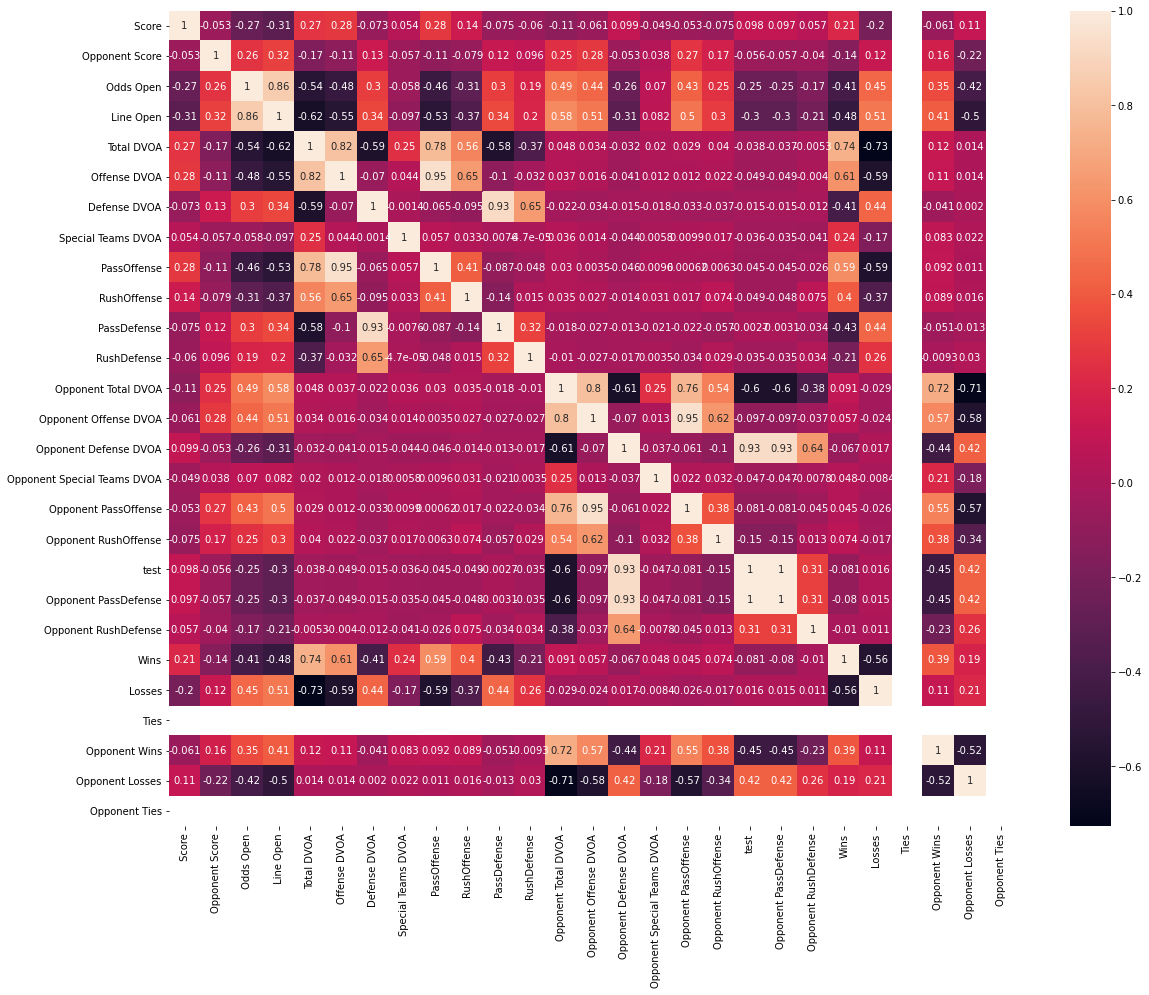

In [270]:
f = plt.figure(figsize=(19, 15))
corrMatrix = datanumerical.corr()
sn.heatmap(corrMatrix, annot=True)
plt.matshow(df.corr(), fignum=f.number)


In [192]:
def basic_information(df):
    df_cols=list(df.columns)
    print("Basic information")
    print("Shape of DF:", df.shape)

    for col in df_cols:
        print("----------------")
        print("Name: {}".format(df[col].name))
        print("Type: {}".format(df[col].dtype))
        print("Unique values: {}".format(len(df[col].unique())))
        print("NaN values: {}".format(df[col].isna().sum()))
        print("0 values: {}".format(df[col].isin([0]).sum()))
        sns.distplot(df[col],bins=20)
        plt.show()

Basic information
Shape of DF: (2213, 15)
----------------
Name: Line Open
Type: float64
Unique values: 68
NaN values: 0
0 values: 35


C:\Users\Nickolaus Smith\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


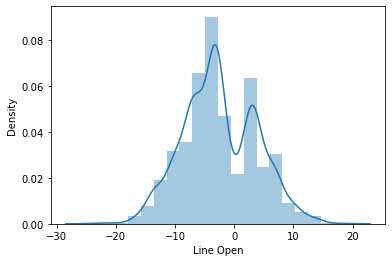

----------------
Name: Total DVOA
Type: float64
Unique values: 757
NaN values: 0
0 values: 4


C:\Users\Nickolaus Smith\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


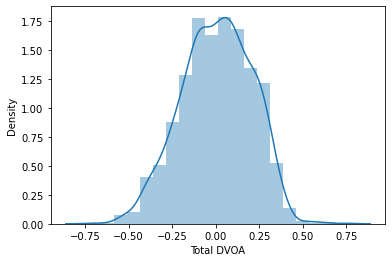

----------------
Name: Special Teams DVOA
Type: float64
Unique values: 232
NaN values: 0
0 values: 28


C:\Users\Nickolaus Smith\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


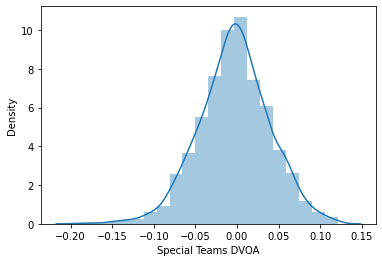

----------------
Name: PassOffense
Type: float64
Unique values: 797
NaN values: 0
0 values: 3


C:\Users\Nickolaus Smith\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


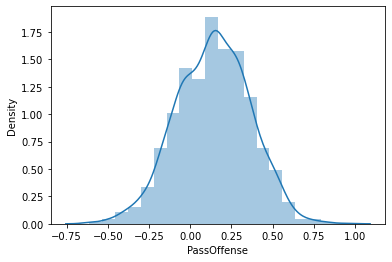

----------------
Name: RushOffense
Type: float64
Unique values: 533
NaN values: 0
0 values: 0


C:\Users\Nickolaus Smith\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


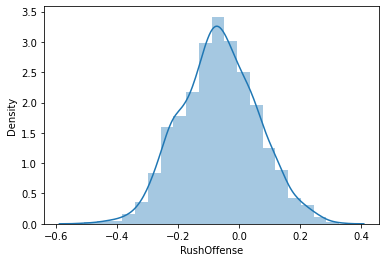

----------------
Name: PassDefense
Type: float64
Unique values: 630
NaN values: 0
0 values: 3


C:\Users\Nickolaus Smith\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


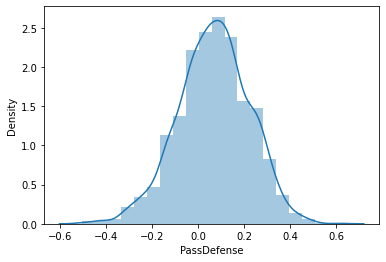

----------------
Name: RushDefense
Type: float64
Unique values: 482
NaN values: 0
0 values: 4


C:\Users\Nickolaus Smith\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


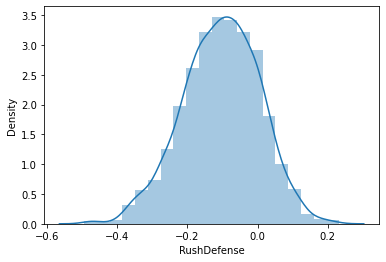

----------------
Name: Opponent Total DVOA
Type: float64
Unique values: 742
NaN values: 0
0 values: 1


C:\Users\Nickolaus Smith\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


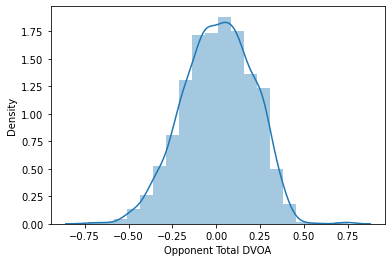

----------------
Name: Opponent Special Teams DVOA
Type: float64
Unique values: 231
NaN values: 0
0 values: 29


C:\Users\Nickolaus Smith\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


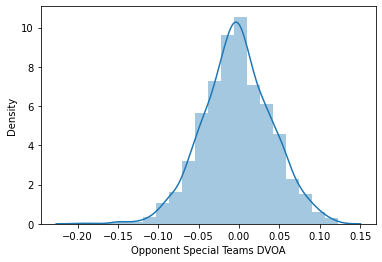

----------------
Name: Opponent PassOffense
Type: float64
Unique values: 802
NaN values: 0
0 values: 3


C:\Users\Nickolaus Smith\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


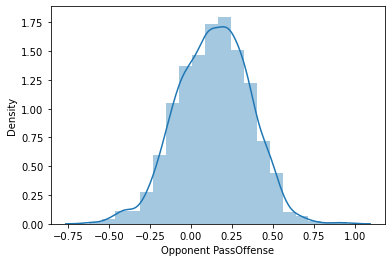

----------------
Name: Opponent RushOffense
Type: float64
Unique values: 537
NaN values: 0
0 values: 5


C:\Users\Nickolaus Smith\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


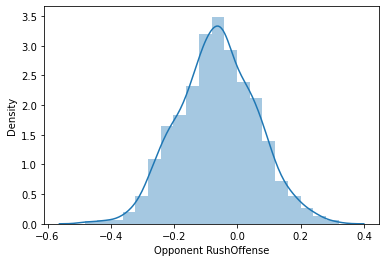

----------------
Name: Opponent PassDefense
Type: float64
Unique values: 636
NaN values: 0
0 values: 6


C:\Users\Nickolaus Smith\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


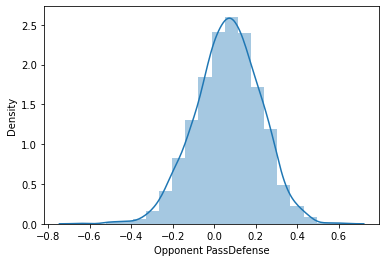

----------------
Name: Opponent RushDefense
Type: float64
Unique values: 486
NaN values: 0
0 values: 6


C:\Users\Nickolaus Smith\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


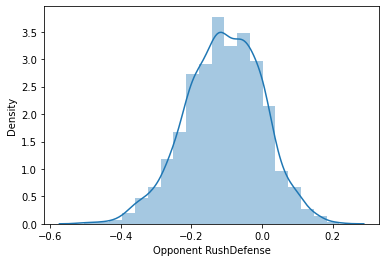

----------------
Name: Playoff Game?_N
Type: uint8
Unique values: 2
NaN values: 0
0 values: 167


C:\Users\Nickolaus Smith\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


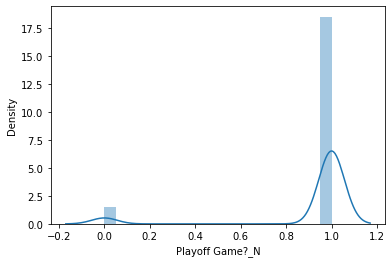

----------------
Name: Playoff Game?_Y
Type: uint8
Unique values: 2
NaN values: 0
0 values: 2046


C:\Users\Nickolaus Smith\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


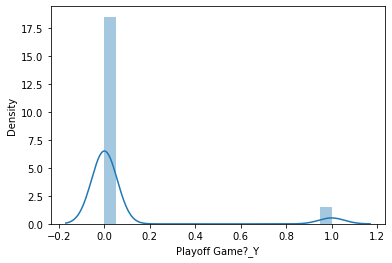

In [193]:
basic_information(features_final)

In [14]:
features_final=features_final.drop(['Offense DVOA','Defense DVOA','Opponent Offense DVOA','Opponent Defense DVOA','Win %', 'Opponent Win %'],axis=1)

In [15]:
features_final

,Line Open,Total DVOA,Special Teams DVOA,PassOffense,RushOffense,PassDefense,RushDefense,Opponent Total DVOA,Opponent Special Teams DVOA,Opponent PassOffense,Opponent RushOffense,Opponent PassDefense,Opponent RushDefense,Playoff Game?_N,Playoff Game?_Y
0,3.5,0.316,-0.029,0.371,-0.020,-0.054,-0.314,0.195,0.005,0.490,-0.056,0.067,0.026,0,1
1,-2.5,0.195,0.005,0.490,-0.056,0.067,0.026,0.238,0.059,0.433,-0.150,0.022,-0.082,0,1
2,-4.0,0.259,-0.027,0.520,0.030,0.051,-0.057,0.316,-0.029,0.371,-0.020,-0.054,-0.314,0,1
3,-3.5,0.333,0.036,0.166,0.095,-0.147,-0.256,0.316,-0.029,0.371,-0.020,-0.054,-0.314,0,1
4,-10.0,0.195,0.005,0.490,-0.056,0.067,0.026,-0.056,-0.037,0.209,-0.008,0.164,-0.054,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4425,4.0,-0.297,-0.027,0.105,-0.089,0.294,0.160,-0.045,-0.011,-0.124,-0.127,-0.020,-0.285,1,0
4426,-13.0,0.314,0.058,0.499,0.087,0.005,-0.045,-0.068,0.036,-0.106,-0.125,-0.006,-0.036,1,0
4427,-3.0,0.148,-0.077,0.248,-0.131,-0.163,-0.264,0.129,-0.018,0.035,0.195,0.013,-0.138,1,0
4428,-13.0,0.318,0.012,0.336,0.207,-0.093,-0.172,-0.334,-0.018,0.025,-0.114,0.430,0.043,1,0


In [16]:
X=features_final
y=targets[['Score','Opponent Score']]

In [17]:
y['Score'].value_counts

<bound method IndexOpsMixin.value_counts of 0       31
1       38
2       26
3       20
4       22
        ..
4425     9
4426    32
4427    20
4428    14
4429    20
Name: Score, Length: 2213, dtype: int64>

In [204]:
LR_final,z,q=run_model(linear_model.LinearRegression(),X,y,"yes")

The MSE value is:  92.3073
The RMSE value is:  9.6077
The R2 value is:  0.0954
The R_adj^{2} value  is:  0.0744
The MSE value is:  80.4546
The RMSE value is:  8.9697
The R2 value is:  0.1488
The R_adj^{2} value  is:  0.1291
Model Results
The accuracy of the model on test set is: 0.54 
The Kappa of your model is: 0.06
<function cohen_kappa_score at 0x00000299A8B25A60>
------ Classification_Report------ 
              precision    recall  f1-score   support

          No       0.58      0.59      0.58       364
         Yes       0.49      0.47      0.48       300

    accuracy                           0.54       664
   macro avg       0.53      0.53      0.53       664
weighted avg       0.54      0.54      0.54       664



In [245]:
LR_final=pd.DataFrame(LR_final)

In [246]:
LR_final

,Line Open,Total DVOA,Special Teams DVOA,PassOffense,RushOffense,PassDefense,RushDefense,Opponent Total DVOA,Opponent Special Teams DVOA,Opponent PassOffense,Opponent RushOffense,Opponent PassDefense,Opponent RushDefense,Playoff Game?_N,Playoff Game?_Y,Score,Opponent Score,predictions,opp predictions,Cover?,Pred_Cover?
812,-7.0,0.227,-0.076,0.509,0.046,0.009,-0.141,0.101,-0.043,0.042,0.087,-0.112,-0.096,1,0,22,23,27.558376,20.567545,No,No
2593,3.0,0.027,-0.079,0.323,0.020,0.256,-0.197,0.313,0.017,0.452,-0.145,-0.014,-0.183,1,0,20,24,25.904742,26.047822,No,Yes
4104,-3.0,-0.152,-0.054,-0.076,-0.209,-0.084,-0.101,-0.155,-0.077,0.202,-0.107,0.244,0.012,1,0,11,27,22.999558,20.906892,No,No
4248,4.0,-0.075,-0.056,-0.141,0.127,0.007,-0.042,0.164,-0.015,0.282,0.153,0.048,-0.120,1,0,28,38,18.646513,25.163455,No,No
3582,-2.0,0.288,0.012,0.149,0.051,-0.159,-0.266,0.041,-0.041,0.155,0.066,-0.025,-0.065,1,0,44,6,21.728475,20.126486,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2318,1.0,0.126,-0.030,0.367,0.138,0.232,-0.132,-0.057,-0.039,0.254,0.116,0.277,-0.044,1,0,13,27,24.104153,24.468855,No,Yes
3023,-3.5,0.065,-0.014,0.165,-0.067,0.050,-0.197,-0.021,0.016,0.116,-0.130,0.031,-0.038,1,0,27,34,23.674389,20.339324,No,No
1088,-2.5,0.065,0.053,0.123,0.062,0.077,0.024,0.010,-0.098,0.342,-0.170,-0.074,-0.010,1,0,6,28,25.489670,20.218994,No,Yes
2820,2.0,-0.338,-0.029,-0.279,-0.138,-0.019,0.053,-0.145,-0.077,0.137,0.194,0.220,0.137,1,0,19,38,17.680790,24.180001,No,No


In [19]:
RF_final,X_train_scaled,y_train=run_model(RandomForestRegressor(max_depth=None, random_state=10,min_samples_split=3,min_samples_leaf=3),X,y,"yes")

The MSE value is:  95.9993
The RMSE value is:  9.7979
The R2 value is:  0.0592
The R_adj^{2} value  is:  0.0374
The MSE value is:  81.9506
The RMSE value is:  9.0527
The R2 value is:  0.133
The R_adj^{2} value  is:  0.1129
Model Results
The accuracy of the model on test set is: 0.55 
The Kappa of your model is: 0.09
<function cohen_kappa_score at 0x00000299A8B25A60>
------ Classification_Report------ 
              precision    recall  f1-score   support

          No       0.59      0.60      0.59       364
         Yes       0.50      0.50      0.50       300

    accuracy                           0.55       664
   macro avg       0.55      0.55      0.55       664
weighted avg       0.55      0.55      0.55       664



In [23]:
RF_final['Opponent PassDefense'].value_counts

<bound method IndexOpsMixin.value_counts of 812    -0.112
2593   -0.014
4104    0.244
4248    0.048
3582   -0.025
        ...  
2318    0.277
3023    0.031
1088   -0.074
2820    0.220
3530    0.173
Name: Opponent PassDefense, Length: 664, dtype: float64>

In [170]:
mse = mean_squared_error
mse = make_scorer(mean_squared_error)

In [172]:
    
    gridf = GridSearchCV(RandomForestRegressor(), param_grid={'max_depth':[1,2,3],'min_samples_split':[1,2,3],'min_samples_leaf':[1,2,3,4]},scoring=mse, n_jobs =2)
    gridf.fit(X_train_scaled, y_train['Score'])
    print(gridf.best_params_,gridf.best_score_,gridf.best_estimator_)
    

{'max_depth': 1, 'min_samples_leaf': 3, 'min_samples_split': 3} 103.41946761566228 RandomForestRegressor(max_depth=1, min_samples_leaf=3, min_samples_split=3)


In [182]:
def run_model2(model,X,Y,scaled):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
    
    
    if scaled=="yes":
        scaler_x = StandardScaler().fit(X_train)
        X_train_scaled = pd.DataFrame(scaler_x.transform(X_train),columns=X.columns)
        X_test_scaled = pd.DataFrame(scaler_x.transform(X_test),columns=X.columns)
    elif scaled=="no":
        X_train_scaled=X_train
        X_test_scaled=X_test
    pm = model
    regression = pm.fit(X_train_scaled, y_train['Score'])
    predictions = regression.predict(X_test_scaled)
    predictions_df = pd.DataFrame(predictions,columns=["pred_scores"])
    mse = mean_squared_error(y_test['Score'], predictions)
    print("The MSE value is: ",round(mse,4))
    
    rmse = math.sqrt(mse)
    print("The RMSE value is: ",round(rmse,4))
    
    r2 = r2_score(y_test['Score'], predictions)
    print("The R2 value is: ",round(r2,4))
    
    N = len(X_test_scaled)
    p = X_test_scaled.shape[1]
    adj_r2 = 1-((1-r2)*(N-1)/(N-p-1))
    print("The R_adj^{2} value  is: ",round(adj_r2,4))

    regression2 = pm.fit(X_train_scaled, y_train['Opponent Score'])
    predictions2 = regression2.predict(X_test_scaled)
    predictions_df2 = pd.DataFrame(predictions2,columns=["Opp_pred_scores"])
    
    
    mse = mean_squared_error(y_test['Opponent Score'], predictions2)
    print("The MSE value is: ",round(mse,4))
    
    rmse = math.sqrt(mse)
    print("The RMSE value is: ",round(rmse,4))
    
    r2 = r2_score(y_test['Opponent Score'], predictions2)
    print("The R2 value is: ",round(r2,4))
    
    N = len(X_test_scaled)
    p = X_test_scaled.shape[1]
    adj_r2 = 1-((1-r2)*(N-1)/(N-p-1))
    print("The R_adj^{2} value  is: ",round(adj_r2,4))
    
    final=pd.concat([X_test, y_test],axis=1)
    passoff=list(final['PassOffense'])
    rushoff=list(final['RushOffense'])
    opppassdef=list(final['Opponent PassDefense'])
    opprushdef=list(final['Opponent RushDefense'])
    opppassoff=list(final['Opponent PassOffense'])
    opprushoff=list(final['Opponent RushOffense'])
    passdef=list(final['PassDefense'])
    rushdef=list(final['RushDefense'])
    for i in range (len(passoff)):
        if (passoff[i]+opppassdef[i])>0:
            predictions[i]=predictions[i]+1
    for i in range (len(passoff)):
        if (rushoff[i]+opprushdef[i])>0:
            predictions[i]=predictions[i]+1
    for i in range (len(passoff)):
        if (opppassoff[i]+passdef[i])>0:
            predictions2[i]=predictions2[i]+1
    for i in range (len(rushoff)):
        if (opprushoff[i]+rushdef[i])>0:
            predictions2[i]=predictions2[i]+1
    
    final['predictions']=predictions
    final['opp predictions']=predictions2
    
    finalscore=list(final['Score'])
    finalline=list(final['Line Open'])
    finalopp=list(final['Opponent Score'])
    finalcover=[]
    for i in range(len(finalscore)):
        if (finalscore[i]+finalline[i])*1.0>finalopp[i]:
            finalcover.append('Yes')
        else:
            finalcover.append('No')
    final['Cover?']=finalcover
    
    predfinalscore=list(final['predictions'])
    predfinalline=list(final['Line Open'])
    predfinalopp=list(final['opp predictions'])
    predfinalcover=[]

      
    for i in range(len(predfinalscore)):
        if (predfinalscore[i])+predfinalline[i]>(predfinalopp[i]):
            predfinalcover.append('Yes')
        else:
            predfinalcover.append('No')
    
    safebet=[]
    for i in range(len(finalscore)):
        if (predfinalscore[i]+predfinalline[i])>(predfinalopp[i]+5):
            safebet.append('Yes')
        elif (predfinalscore[i]+(predfinalline[i]+3.5))<predfinalopp[i]:   
            safebet.append('Yes')
        else:
            safebet.append('No')
    final['safebet?']=safebet

    final['Pred_Cover?']=predfinalcover  
    final['Cover?']=finalcover
    
    safepredfinalscore=list(final['predictions'][final['safebet?'] == 'Yes'])
    safepredfinalline=list(final['Line Open'][final['safebet?'] == 'Yes'])
    safepredfinalopp=list(final['opp predictions'][final['safebet?'] == 'Yes'])
    safepredfinalcover=[]

      
    for i in range(len(safepredfinalscore)):
        if (safepredfinalscore[i])+safepredfinalline[i]>(safepredfinalopp[i]):
            safepredfinalcover.append('Yes')
        else:
            safepredfinalcover.append('No')
    
    print("Model Results")
    print("The accuracy of the model on test set is: %4.2f " % accuracy_score(final['Cover?'], predfinalcover))
    print("The Kappa of your model is: %4.2f" % (cohen_kappa_score(final['Cover?'], predfinalcover)))
    print(cohen_kappa_score)
    print("------ Classification_Report------ ")
    print(classification_report(final['Cover?'], predfinalcover))
    print(" =================================================================== ")
    


    print("Safe Model Results")
    print("The accuracy of the model on test set is: %4.2f " % accuracy_score(final['Cover?'][final['safebet?'] == 'Yes'], safepredfinalcover))
    print("The Kappa of your model is: %4.2f" % (cohen_kappa_score(final['Cover?'][final['safebet?'] == 'Yes'], safepredfinalcover)))
    print(cohen_kappa_score)
    print("------ Classification_Report------ ")
    print(classification_report(final['Cover?'][final['safebet?'] == 'Yes'], safepredfinalcover))
    print(" =================================================================== ")
    return final,X_train_scaled,y_train


In [252]:
RF_final2,X_train_scaled,y_train=run_model2(RandomForestRegressor(max_depth=None, random_state=10,min_samples_split=3,min_samples_leaf=3),X,y,"yes")

The MSE value is:  95.9993
The RMSE value is:  9.7979
The R2 value is:  0.0592
The R_adj^{2} value  is:  0.0374
The MSE value is:  81.9506
The RMSE value is:  9.0527
The R2 value is:  0.133
The R_adj^{2} value  is:  0.1129
Model Results
The accuracy of the model on test set is: 0.56 
The Kappa of your model is: 0.11
<function cohen_kappa_score at 0x00000299A8B25A60>
------ Classification_Report------ 
              precision    recall  f1-score   support

          No       0.60      0.61      0.60       364
         Yes       0.51      0.50      0.51       300

    accuracy                           0.56       664
   macro avg       0.55      0.55      0.55       664
weighted avg       0.56      0.56      0.56       664

Safe Model Results
The accuracy of the model on test set is: 0.61 
The Kappa of your model is: 0.11
<function cohen_kappa_score at 0x00000299A8B25A60>
------ Classification_Report------ 
              precision    recall  f1-score   support

          No       0.65   

In [133]:
for i in range(len(test)):
    print(test[i]+3)

23.919859307359307
32.244119741369744
24.80288041125541
29.251216810966817
21.932626623376624
29.03883477633478
30.91162087912088
25.106953296703296
30.19581493506493
32.294990120990136
29.944232323232317
26.54921608946609
25.164606449106437
28.240757936507933
23.093176351426347
24.739619047619055
31.763441919191923
29.308321067821062
27.619060606060604
25.582464646464647
24.269582251082255
21.536072649572652
20.69757864357864
29.47689502164503
31.07906204906206
26.257915584415592
18.205273088023084
28.20418037518037
27.965175685425688
24.827318542568545
20.158371101121105
17.66544047619048
28.349067099567097
23.47508910533911
32.739134199134185
29.764453102453103
24.673158313908317
23.812912615162624
22.614755577755574
26.326061355311364
26.64700072150073
23.75824847374847
29.074635475635475
27.359500000000004
28.90162301587301
32.22969774669775
23.040573121323124
30.238471889221888
24.676404456654453
22.347336219336224
21.38889083139083
26.925173520923522
30.179609307359307
23.789878

In [99]:
RF_final2['Cover?'][RF_final2['safebet?'] == 'Yes']

4248     No
2758    Yes
3973     No
1585    Yes
2883     No
       ... 
8       Yes
2318     No
1088     No
2820     No
3530    Yes
Name: Cover?, Length: 268, dtype: object

In [117]:
RF_final2['Pred_Cover?'][RF_final2['safebet?'] == 'Yes']

4248     No
2758     No
3973     No
1585     No
2883     No
       ... 
8       Yes
2318    Yes
1088    Yes
2820     No
3530    Yes
Name: Pred_Cover?, Length: 268, dtype: object

In [102]:
safepredfinalscore=list(RF_final2['predictions'][RF_final2['safebet?'] == 'Yes'])

In [103]:
safepredfinalscore

[18.963783189033187,
 18.860973026973028,
 17.32516666666667,
 19.010254662004662,
 17.892500721500724,
 17.552096320346312,
 23.04880303030303,
 26.988473304473306,
 25.246752525252518,
 20.454124819624827,
 24.354690143190137,
 16.700992424242425,
 33.577519841269854,
 26.466859307359314,
 24.589838217338226,
 15.768198412698414,
 25.174260101010105,
 17.770987734487736,
 11.786408591408588,
 26.41185947385947,
 28.902564990564983,
 22.39454076479076,
 20.993104256854252,
 24.20231102231102,
 29.244511183261178,
 28.41591305916305,
 25.858505050505055,
 28.506215090465094,
 27.774777417027416,
 30.98240079365079,
 38.64240043290042,
 18.645805555555565,
 18.308979770229765,
 18.372503968253973,
 19.2851727994228,
 25.19511371961373,
 26.35746861471861,
 24.956005494505497,
 21.951178571428567,
 22.814401709401707,
 32.60086116661117,
 29.66289341214342,
 23.50558261183261,
 27.598797619047613,
 20.925322566322563,
 25.138560966810974,
 28.469642857142865,
 20.308672438672442,
 19.060

In [165]:
RF_final2['Pred_Cover?'][RF_final2['safebet?'] == 'Yes'].value_counts()

No     117
Yes     65
Name: Pred_Cover?, dtype: int64

In [218]:
RF_final2

,Line Open,Total DVOA,Special Teams DVOA,PassOffense,RushOffense,PassDefense,RushDefense,Opponent Total DVOA,Opponent Special Teams DVOA,Opponent PassOffense,Opponent RushOffense,Opponent PassDefense,Opponent RushDefense,Playoff Game?_N,Playoff Game?_Y,Score,Opponent Score,predictions,opp predictions,Cover?,safebet?,Pred_Cover?
812,-7.0,0.227,-0.076,0.509,0.046,0.009,-0.141,0.101,-0.043,0.042,0.087,-0.112,-0.096,1,0,22,23,29.193235,20.919859,No,No,Yes
2593,3.0,0.027,-0.079,0.323,0.020,0.256,-0.197,0.313,0.017,0.452,-0.145,-0.014,-0.183,1,0,20,24,23.476570,29.244120,No,No,No
4104,-3.0,-0.152,-0.054,-0.076,-0.209,-0.084,-0.101,-0.155,-0.077,0.202,-0.107,0.244,0.012,1,0,11,27,24.080827,21.802880,No,No,No
4248,4.0,-0.075,-0.056,-0.141,0.127,0.007,-0.042,0.164,-0.015,0.282,0.153,0.048,-0.120,1,0,28,38,18.963783,26.251217,No,No,No
3582,-2.0,0.288,0.012,0.149,0.051,-0.159,-0.266,0.041,-0.041,0.155,0.066,-0.025,-0.065,1,0,44,6,23.246640,18.932627,Yes,No,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2318,1.0,0.126,-0.030,0.367,0.138,0.232,-0.132,-0.057,-0.039,0.254,0.116,0.277,-0.044,1,0,13,27,29.230558,26.257614,No,No,Yes
3023,-3.5,0.065,-0.014,0.165,-0.067,0.050,-0.197,-0.021,0.016,0.116,-0.130,0.031,-0.038,1,0,27,34,24.190978,23.130547,No,No,No
1088,-2.5,0.065,0.053,0.123,0.062,0.077,0.024,0.010,-0.098,0.342,-0.170,-0.074,-0.010,1,0,6,28,25.722050,18.738504,No,No,Yes
2820,2.0,-0.338,-0.029,-0.279,-0.138,-0.019,0.053,-0.145,-0.077,0.137,0.194,0.220,0.137,1,0,19,38,19.110860,27.522925,No,Yes,No


In [231]:
rfpred=list(RF_final2['Pred_Cover?'])
LRpred=list(LR_final['Pred_Cover?'])
combo=[]

In [232]:
for i in range(len(rfpred)):
    if rfpred[i]==LRpred[i]:
        combo.append('Yes')
    else:   
        combo.append('No')

In [233]:
len(combo)

664

In [234]:
    print("Model Results")
    print("The accuracy of the model on test set is: %4.2f " % accuracy_score(RF_final2['Cover?'], combo))
    print("The Kappa of your model is: %4.2f" % (cohen_kappa_score(RF_final2['Cover?'], combo)))
    print(cohen_kappa_score)
    print("------ Classification_Report------ ")
    print(classification_report(RF_final2['Cover?'], combo))
    print(" =================================================================== ")

Model Results
The accuracy of the model on test set is: 0.49 
The Kappa of your model is: 0.02
<function cohen_kappa_score at 0x00000299A8B25A60>
------ Classification_Report------ 
              precision    recall  f1-score   support

          No       0.56      0.36      0.44       364
         Yes       0.46      0.66      0.54       300

    accuracy                           0.49       664
   macro avg       0.51      0.51      0.49       664
weighted avg       0.51      0.49      0.48       664



In [235]:
combodf=RF_final2

In [236]:
combodf['combo']=combo

In [237]:
combodf

,Line Open,Total DVOA,Special Teams DVOA,PassOffense,RushOffense,PassDefense,RushDefense,Opponent Total DVOA,Opponent Special Teams DVOA,Opponent PassOffense,Opponent RushOffense,Opponent PassDefense,Opponent RushDefense,Playoff Game?_N,Playoff Game?_Y,Score,Opponent Score,predictions,opp predictions,Cover?,safebet?,Pred_Cover?,combo
812,-7.0,0.227,-0.076,0.509,0.046,0.009,-0.141,0.101,-0.043,0.042,0.087,-0.112,-0.096,1,0,22,23,29.193235,20.919859,No,No,Yes,No
2593,3.0,0.027,-0.079,0.323,0.020,0.256,-0.197,0.313,0.017,0.452,-0.145,-0.014,-0.183,1,0,20,24,23.476570,29.244120,No,No,No,No
4104,-3.0,-0.152,-0.054,-0.076,-0.209,-0.084,-0.101,-0.155,-0.077,0.202,-0.107,0.244,0.012,1,0,11,27,24.080827,21.802880,No,No,No,Yes
4248,4.0,-0.075,-0.056,-0.141,0.127,0.007,-0.042,0.164,-0.015,0.282,0.153,0.048,-0.120,1,0,28,38,18.963783,26.251217,No,No,No,Yes
3582,-2.0,0.288,0.012,0.149,0.051,-0.159,-0.266,0.041,-0.041,0.155,0.066,-0.025,-0.065,1,0,44,6,23.246640,18.932627,Yes,No,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2318,1.0,0.126,-0.030,0.367,0.138,0.232,-0.132,-0.057,-0.039,0.254,0.116,0.277,-0.044,1,0,13,27,29.230558,26.257614,No,No,Yes,Yes
3023,-3.5,0.065,-0.014,0.165,-0.067,0.050,-0.197,-0.021,0.016,0.116,-0.130,0.031,-0.038,1,0,27,34,24.190978,23.130547,No,No,No,Yes
1088,-2.5,0.065,0.053,0.123,0.062,0.077,0.024,0.010,-0.098,0.342,-0.170,-0.074,-0.010,1,0,6,28,25.722050,18.738504,No,No,Yes,Yes
2820,2.0,-0.338,-0.029,-0.279,-0.138,-0.019,0.053,-0.145,-0.077,0.137,0.194,0.220,0.137,1,0,19,38,19.110860,27.522925,No,Yes,No,Yes


In [238]:
combodf2=combodf['combo?'] == 'Yes']

SyntaxError: unmatched ']' (<ipython-input-238-75f26ada0c63>, line 1)

In [247]:
combodf2=combodf[combodf['combo'] == 'Yes']

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [249]:
combodfsafe=combodf2[combodf2['safebet?'] == 'Yes']

In [250]:
combodfsafe

,Line Open,Total DVOA,Special Teams DVOA,PassOffense,RushOffense,PassDefense,RushDefense,Opponent Total DVOA,Opponent Special Teams DVOA,Opponent PassOffense,Opponent RushOffense,Opponent PassDefense,Opponent RushDefense,Playoff Game?_N,Playoff Game?_Y,Score,Opponent Score,predictions,opp predictions,Cover?,safebet?,Pred_Cover?,combo
2883,-3.0,-0.316,-0.024,-0.196,-0.105,0.045,0.074,-0.184,-0.025,-0.013,-0.103,0.142,-0.137,1,0,7,24,17.892501,21.739619,No,Yes,No,Yes
482,2.5,0.029,0.012,0.059,-0.035,0.052,-0.223,0.317,0.018,0.454,0.167,-0.062,-0.023,1,0,6,45,17.552096,28.763442,No,Yes,No,Yes
3854,-8.0,0.205,0.030,0.320,0.029,0.045,-0.089,0.014,-0.009,-0.030,0.109,0.029,-0.113,0,1,20,23,26.988473,22.582465,No,Yes,No,Yes
1413,-4.0,-0.043,-0.053,0.123,-0.023,0.122,-0.223,0.055,-0.041,0.409,-0.043,0.194,-0.107,1,0,23,20,26.466859,26.074635,No,Yes,No,Yes
1347,1.0,-0.045,-0.040,0.173,-0.077,0.110,-0.087,0.157,0.083,0.033,-0.027,-0.120,-0.161,1,0,32,14,24.589838,29.229698,Yes,Yes,No,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
809,-3.0,0.196,-0.065,0.295,-0.107,-0.082,-0.354,0.050,-0.038,0.126,-0.216,-0.004,-0.282,1,0,25,20,27.269696,17.085430,Yes,Yes,Yes,Yes
4216,7.0,-0.348,-0.048,-0.403,-0.164,-0.141,-0.012,0.058,0.016,0.229,-0.033,0.067,-0.058,1,0,9,20,13.664698,25.629244,No,Yes,No,Yes
3411,9.0,-0.131,-0.014,-0.021,-0.178,0.050,-0.120,0.394,-0.032,0.438,0.206,-0.261,0.009,1,0,30,33,17.507224,30.359700,Yes,Yes,No,Yes
4241,-3.5,-0.056,-0.054,-0.142,-0.037,-0.004,-0.372,-0.067,0.040,0.175,-0.019,0.122,0.155,1,0,13,26,19.018897,26.341479,No,Yes,No,Yes


In [243]:
    print("Model Results")
    print("The accuracy of the model on test set is: %4.2f " % accuracy_score(combodf2['Cover?'], combodf2['Pred_Cover?']))
    print("The Kappa of your model is: %4.2f" % (cohen_kappa_score(combodf2['Cover?'], combodf2['Pred_Cover?'])))
    print(cohen_kappa_score)
    print("------ Classification_Report------ ")
    print(classification_report(combodf2['Cover?'], combodf2['Pred_Cover?']))
    print(" =================================================================== ")

Model Results
The accuracy of the model on test set is: 0.57 
The Kappa of your model is: 0.14
<function cohen_kappa_score at 0x00000299A8B25A60>
------ Classification_Report------ 
              precision    recall  f1-score   support

          No       0.60      0.66      0.63       233
         Yes       0.54      0.48      0.51       197

    accuracy                           0.57       430
   macro avg       0.57      0.57      0.57       430
weighted avg       0.57      0.57      0.57       430



In [251]:
    print("Model Results")
    print("The accuracy of the model on test set is: %4.2f " % accuracy_score(combodfsafe['Cover?'], combodfsafe['Pred_Cover?']))
    print("The Kappa of your model is: %4.2f" % (cohen_kappa_score(combodfsafe['Cover?'], combodfsafe['Pred_Cover?'])))
    print(cohen_kappa_score)
    print("------ Classification_Report------ ")
    print(classification_report(combodfsafe['Cover?'], combodfsafe['Pred_Cover?']))
    print(" =================================================================== ")

Model Results
The accuracy of the model on test set is: 0.62 
The Kappa of your model is: 0.14
<function cohen_kappa_score at 0x00000299A8B25A60>
------ Classification_Report------ 
              precision    recall  f1-score   support

          No       0.66      0.80      0.73        81
         Yes       0.50      0.33      0.40        49

    accuracy                           0.62       130
   macro avg       0.58      0.56      0.56       130
weighted avg       0.60      0.62      0.60       130

